# API testing

In [6]:
# import requests

# data = {"remote_file_path":"temp/10181.jpeg"}

# response = requests.get('http://127.0.0.1:8000/get_image',json=data)


# if response.status_code == 200:
#     with open('received_image.jpeg', 'wb') as f:
#         for chunk in response.iter_content(1024):
#             f.write(chunk)

In [1]:
import requests


files = {'image': ('imagefiles/jpegfiles/10181.jpeg', open('imagefiles/jpegfiles/10181.jpeg', 'rb'))}

response = requests.post('http://127.0.0.1:8000/upload_image',files= files)
response.json()

{'message': "Image uploaded to '/data/biofilm/10181.jpeg' on the remote server"}

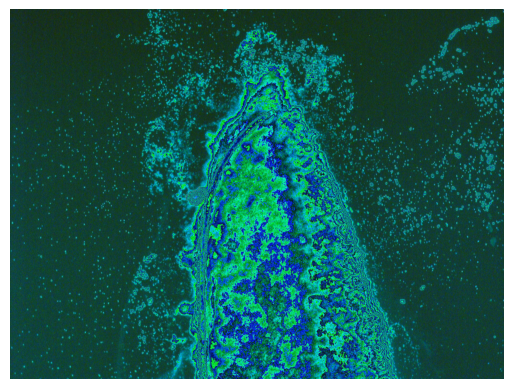

In [2]:
import io
import requests
import matplotlib.pyplot as plt
from PIL import Image

data = {"remote_file_name":"10181.jpeg"}

response = requests.get('http://127.0.0.1:8000/get_image',json=data)

image_data = response.content
image = Image.open(io.BytesIO(image_data))
plt.imshow(image)
plt.axis('off') 
plt.show()

#  working with czi files

In [ ]:
# !pip install czifile pillow

In [2]:
import os
import sys
import czifile
import numpy as np
from PIL import Image

def czi_to_jpeg(input_file, output_dir):
    czi_data = czifile.imread(input_file)

    for i, scene in enumerate(czi_data):
        scaled_data = (scene * 255.0 / scene.max()).astype(np.uint8)

        img = Image.fromarray(scaled_data)
        output_file = "output_"+str(i)+".jpeg"

        # Save the image as a JPEG
        img.save(output_file, "JPEG")


input_file = 'imagefiles/pa01_rep1/Snap-10181.czi'
output_dir = 'imagefiles/'

czi_to_jpeg(input_file, output_dir)


In [ ]:
import os
import glob
import czifile
import numpy as np
from PIL import Image

for filename in glob.glob('imagefiles/pa01_rep1/*.czi'):
    outputfile_name = filename.split('/')[1].split('-')[1].split('.')[0]+'.jpeg'
    czi_data = czifile.imread(filename)
    scaled_data = czi_data[0].astype(np.uint8)
#     scaled_data = (czi_data[0] * 255.0 / czi_data[0].max()).astype(np.uint8)
    img = Image.fromarray(scaled_data)
    img.save('imagefiles/jpegfiles'+'/'+outputfile_name, "JPEG")

In [4]:
x = 'Snap-10181.czi'
x.split('.')[0]+'.jpeg'

'Snap-10181.jpeg'

# working with remote connection

In [ ]:
# !pip install paramiko


In [ ]:
import paramiko

remote_host = "69.71.169.180"
remote_port = 42935
remote_username = "achalumuru"
remote_password = "EArxW_@VK4FY"
file_name = "10181.jpeg"

ssh_client = paramiko.SSHClient()
ssh_client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
ssh_client.connect(remote_host, port=remote_port, username=remote_username, password=remote_password)
remote_command = "ls -l"
stdin, stdout, stderr = ssh_client.exec_command(remote_command)
command_output = stdout.read().decode()
print(command_output)

ssh_client.close()


In [ ]:
import io
import paramiko
from PIL import Image
import matplotlib.pyplot as plt

remote_host = "69.71.169.180"
remote_port = 42935
remote_username = "achalumuru"
remote_password = "EArxW_@VK4FY"
remote_file_path = "temp/10181.jpeg"

ssh_client = paramiko.SSHClient()
ssh_client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
ssh_client.connect(remote_host, port=remote_port, username=remote_username, password=remote_password)
sftp = ssh_client.open_sftp()
with sftp.file(remote_file_path, 'rb') as remote_file:
    image_data = remote_file.read()
    image = Image.open(io.BytesIO(image_data))
    
plt.imshow(image)
plt.axis('off')
plt.show()
sftp.close()
ssh_client.close()


In [ ]:
def remote_server_conn():
    try:
        ssh_client = paramiko.SSHClient()
        ssh_client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
        ssh_client.connect(remote_host, port=remote_port, username=remote_username, password=remote_password)
        sftp = ssh_client.open_sftp() 
        if(ssh_client):
            print('Connection to remote server created successfully')
        return ssh_client
    
    except Exception as e:
            print(f"While processing in Function {remote_server_conn.__qualname__}, we got {sys.exc_info()[0]} Exception. \n '{e}' in Line Number {sys.exc_info()[2].tb_lineno}  File Name {os.path.basename(sys.exc_info()[2].tb_frame.f_code.co_filename)}")
            

In [ ]:
import io
import os
import sys
import paramiko
from PIL import Image
import matplotlib.pyplot as plt

remote_file_path = "temp/10181.jpeg"

remote_host = "69.71.169.180"
remote_port = 42935
remote_username = "achalumuru"
remote_password = "EArxW_@VK4FY"


def retrieve_image():
    ssh_client = remote_server_conn()
    sftp = ssh_client.open_sftp()
    with sftp.file(remote_file_path, 'rb') as remote_file:
        image_data = remote_file.read()
        image = Image.open(io.BytesIO(image_data))
    sftp.close()
    ssh_client.close()
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    
    


retrieve_image()

In [ ]:
import os
import glob
import paramiko

hostname = '69.71.169.180'
port = 42935  
username = 'achalumuru'
password = 'EArxW_@VK4FY'
remote_directory = 'temp/'

client = paramiko.SSHClient()
client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
client.connect(hostname, port, username, password)
sftp = client.open_sftp()

try:
    for file_loc in glob.glob('imagefiles/jpegfiles/*.jpeg'):
        sftp.put(file_loc, remote_directory + file_loc.split('/')[1])
        print(f"File '{file_loc}' transferred successfully to '{remote_directory}' on the server.")
    
finally:
    sftp.close()
    client.close()

# debugging --> cells will be deleted

In [10]:
from core.logger import get_logger
from app.api.process import Process
from app.api.service import db_conn  
from app.api.service import remote_server_conn


processor=Process()
config = processor.config

ssh_client = remote_server_conn()
sftp = ssh_client.open_sftp()

directory_path = '/data/biofilms/test'

check_command = f"[ -d '{directory_path}' ] && echo 'Directory exists' || echo 'Directory does not exist'"
stdin, stdout, stderr = ssh_client.exec_command(check_command)

directory_status = stdout.read().decode('utf-8').strip()

create_command = f"mkdir -p {directory_path}"
stdin, stdout, stderr = ssh_client.exec_command(create_command)


2024-01-10 19:37:35,750 MainThread app.api.service INFO Connection to remote server created successfully


In [6]:
sftp.close()
ssh_client.close()

In [7]:
directory_status

'Directory exists'

In [10]:
check_command

"[ -d '/path/to/your/new_directory' ] && echo 'Directory exists' || echo 'Directory does not exist'"

In [8]:
x = 5
"cdabv {}".format(x)

'cdabv 5'

In [11]:
x = 'a'
y = 'b'

if x=='a' and y =='b':
    print('csa')


csa


In [12]:

if x,y=='a','b':
    print('csa')

SyntaxError: invalid syntax (3062691198.py, line 1)

In [14]:
x = 1
y = 2

if x ==1:
    print('abc')
elif y==2:
    print('def')

abc


In [31]:
create_command = "mkdir -p {}"
experiment_folder = '/data/biofilms/test'
create_command.format(os.path.join(experiment_folder,'jpeg'))

'mkdir -p /data/biofilms/test/jpeg'

In [30]:
experiment_folder = '/data/biofilms/test'
os.path.join(experiment_folder,'jpeg')

'/data/biofilms/test/jpeg'

In [25]:
import os

In [32]:
create_command

'mkdir -p {}'

In [33]:
os.path.join('abc','def','ghi')

'abc/def/ghi'

In [3]:
import czifile
image = 'imagefiles/pa01_rep1/Snap-10183.czi'
czi_data = czifile.imread(image)

In [4]:
czi_data

array([[[[45, 27, 29],
         [43, 25, 27],
         [44, 25, 29],
         ...,
         [44, 31,  4],
         [47, 34,  7],
         [45, 33,  6]],

        [[45, 27, 29],
         [44, 25, 29],
         [43, 25, 27],
         ...,
         [41, 28,  1],
         [47, 34,  7],
         [47, 34,  7]],

        [[47, 27, 30],
         [47, 27, 30],
         [45, 27, 29],
         ...,
         [40, 27,  0],
         [45, 33,  6],
         [46, 32,  4]],

        ...,

        [[35, 28, 54],
         [36, 28, 53],
         [36, 28, 53],
         ...,
         [44, 30, 19],
         [47, 32, 25],
         [53, 37, 29]],

        [[38, 28, 50],
         [36, 28, 50],
         [36, 27, 49],
         ...,
         [44, 30, 20],
         [49, 34, 26],
         [53, 37, 31]],

        [[36, 28, 50],
         [36, 28, 50],
         [36, 27, 49],
         ...,
         [44, 30, 20],
         [49, 34, 26],
         [53, 37, 31]]]], dtype=uint16)

In [ ]:
import paramiko

transport = paramiko.Transport(('69.71.169.180', 42935))
transport.connect(username='achalumuru', password='EArxW_@VK4FY')

sftp = paramiko.SFTPClient.from_transport(transport)

# Specify the remote path where you want to save the file
remote_path = '/path/to/remote/upload/folder/' + secure_filename(file.filename)

# Upload the file using file.stream
with sftp.file(remote_path, 'wb') as remote_file:
    for chunk in iter(lambda: file.stream.read(32768), b''):
        remote_file.write(chunk)

sftp.close()
transport.close()